In [1]:
# Libraries
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from bs4 import BeautifulSoup

import multiprocessing

# nltk:- Natural Language Processing Toolkit
import nltk
from nltk.corpus import stopwords

from sklearn import utils
# spliting data into train and test
from sklearn.model_selection import train_test_split
# For loading Doc2Vec Model
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
# Training Models
from sklearn import model_selection, svm
from sklearn.ensemble import RandomForestClassifier
# For Results
from sklearn.metrics import classification_report, accuracy_score

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\tqdm\std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Loading Dataset

In [2]:
df = pd.read_csv('./Data/Dataset.csv', engine='python')

In [3]:
# For Removing the garbage values at the end of the urls
df = df.replace('\n','', regex=True)
df = df.replace('\r','', regex=True)

In [4]:
df.head(10)

,URLs,Headline,Body,Label
0,http://www.bbc.com,Four ways Bob Corker skewered Donald Trump,"Image copyright Getty ImagesOn Sunday morning,...",1
1,https://www.reuters.com,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - ?Last Flag Flying?, a comed...",1
2,https://www.nytimes.com,Trump?s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt?s Cheiron Holdin...,1
4,http://www.cnn.com,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1
5,http://beforeitsnews.com,JetNation FanDuel League; Week 4,JetNation FanDuel League; Week 4% of readers t...,0
6,https://www.nytimes.com,Kansas Tried a Tax Plan Similar to Trump?s. It...,"In 2012, Kansas lawmakers, led by Gov. Sam Bro...",1
7,https://www.reuters.com,"India RBI chief: growth important, but not at ...",The Reserve Bank of India (RBI) Governor Urjit...,1
8,https://www.reuters.com,EPA chief to sign rule on Clean Power Plan exi...,"Scott Pruitt, Administrator of the U.S. Enviro...",1
9,https://www.reuters.com,Talks on sale of Air Berlin planes to easyJet ...,FILE PHOTO - An Air Berlin sign is seen at an ...,1


In [5]:
df_sources = df[['URLs','Body']]
df_sources.head()

,URLs,Body
0,http://www.bbc.com,"Image copyright Getty ImagesOn Sunday morning,..."
1,https://www.reuters.com,"LONDON (Reuters) - ?Last Flag Flying?, a comed..."
2,https://www.nytimes.com,The feud broke into public view last week when...
3,https://www.reuters.com,MEXICO CITY (Reuters) - Egypt?s Cheiron Holdin...
4,http://www.cnn.com,"Country singer Jason Aldean, who was performin..."


In [6]:
df_sources.shape

(3678, 2)

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


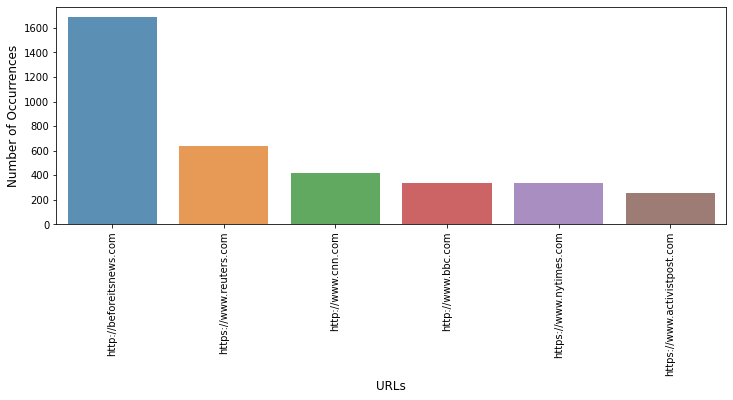

In [7]:
# For showing the occurences of urls in the dataset
cnt_urls = df_sources['URLs'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_urls.index, cnt_urls.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('URLs', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [8]:
# Checking the unique values in Urls
df_sources.URLs.unique()

array(['http://www.bbc.com', 'https://www.reuters.com',
       'https://www.nytimes.com', 'http://www.cnn.com',
       'http://beforeitsnews.com', 'https://www.activistpost.com'],
      dtype=object)

# Data Preprocessing

In [9]:
# cleaning html symbols from the sentence
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

In [10]:
# cleaning punctuations from the sentence
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [11]:
def cleanText(text):
    text = cleanhtml(str(text))
    text = cleanpunc(str(text))
    text = BeautifulSoup(str(text), "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df_sources['Body'] = df_sources['Body'].apply(cleanText)

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [12]:
df_sources.head()

,URLs,Body
0,http://www.bbc.com,image copyright getty imageson sunday morning ...
1,https://www.reuters.com,london reuters - last flag flying a comedy-...
2,https://www.nytimes.com,the feud broke into public view last week when...
3,https://www.reuters.com,meico city reuters - egypts cheiron holdings...
4,http://www.cnn.com,country singer jason aldean who was performin...


## Tokenization

In [13]:
# spliting data into train and test
train, test = train_test_split(df_sources, test_size=0.2, random_state=42)
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Body']), tags=[r.URLs]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Body']), tags=[r.URLs]), axis=1)

In [14]:
train_tagged.values[30]

TaggedDocument(words=['san', 'juan', 'mayor', 'sports', 'help', 'us', 'we', 'are', 'dying', 't-shirt', 'for', 'anti-trump', 'cnn', 'interview', 'before', 'its', 'news', 'cdn', 'url', 'www', 'conservativedailynews', 'comby', 'donn', 'martendemocrats', 'have', 'homed', 'in', 'on', 'hurricane-ravaged', 'puerto', 'rico', 'as', 'this', 'weeks', 'front', 'lines', 'in', 'their', 'endless', 'war', 'on', 'president', 'donald', 'trump', 'the', 'territory', 'was', 'busted', 'back', 'to', 'the', 'stone', 'age', 'by', 'hurricane', 'maria', 'and', 'democrat', 'surrogates', 'in', 'the', 'media', 'have', 'already', 'epressed', 'that', 'they', 'want', 'to', 'turn', 'it', 'into', 'trumps', 'katrina', 'in', 'their', 'relentless', 'quest', 'to', 'damage', 'new', 'president', 'who', 'has', 'yet', 'to', 'be', 'in', 'office', 'one', 'year', 'the', 'newest', 'anti-trump', 'figure', 'that', 'has', 'emerged', 'is', 'san', 'juan', 'mayor', 'carmen', 'yulin', 'cruz', 'who', 'during', 'an', 'interview', 'with', 'c

In [15]:
# For using multiple cores while using doc2vec for feature extraction
cores = multiprocessing.cpu_count()

# Feature Extraction

In [16]:
model_dbow = Doc2Vec(dm=0, vector_size=500, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|█████████████████████████████████████████████████████████████████████████| 2942/2942 [00:00<00:00, 1472159.67it/s]


In [17]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|█████████████████████████████████████████████████████████████████████████| 2942/2942 [00:00<00:00, 1472862.54it/s]


Wall time: 44.4 s


In [18]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [19]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

# Training Models

## 1. SVM

In [20]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test)

### Evalution Measures

In [21]:
# Use accuracy_score and classification_report function to get the accuracy,f1-score, recall, and precision
print(classification_report(y_test,predictions_SVM))
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

                              precision    recall  f1-score   support

    http://beforeitsnews.com       0.47      0.95      0.63       330
          http://www.bbc.com       0.00      0.00      0.00        79
          http://www.cnn.com       0.00      0.00      0.00        75
https://www.activistpost.com       0.00      0.00      0.00        53
     https://www.nytimes.com       0.00      0.00      0.00        56
     https://www.reuters.com       0.37      0.17      0.23       143

                    accuracy                           0.46       736
                   macro avg       0.14      0.19      0.14       736
                weighted avg       0.28      0.46      0.33       736

SVM Accuracy Score ->  45.78804347826087


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2. Random Forest

In [22]:
text_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
text_classifier.fit(X_train, y_train)
predictions = text_classifier.predict(X_test)

### Evalution Measures

In [23]:
# Use accuracy_score and classification_report function to get the accuracy,f1-score, recall, and precision
print(classification_report(y_test,predictions))
print("RF Accuracy Score -> ",accuracy_score(predictions, y_test)*100)

                              precision    recall  f1-score   support

    http://beforeitsnews.com       0.51      0.90      0.65       330
          http://www.bbc.com       0.23      0.08      0.11        79
          http://www.cnn.com       0.43      0.04      0.07        75
https://www.activistpost.com       0.00      0.00      0.00        53
     https://www.nytimes.com       0.00      0.00      0.00        56
     https://www.reuters.com       0.39      0.33      0.35       143

                    accuracy                           0.48       736
                   macro avg       0.26      0.22      0.20       736
                weighted avg       0.37      0.48      0.38       736

RF Accuracy Score ->  47.82608695652174
